# Importing Libraries

In [36]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from tensorflow.python.client import device_lib
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

In [37]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4366786409847885951
xla_global_id: -1
]


2024-05-02 14:38:16.751440: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [38]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU Is Available")
    for device in physical_devices:
        print(f"Device Name: {device.name}")
else:
    print("GPU Is Not Available")

GPU Is Not Available


In [39]:
# Set GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [40]:
# Set seed for reproducibility
np.random.seed(42)

# Loading Metadata

In [41]:
skin_df = pd.read_csv('/home/craib/Desktop/SCDS_Datasets/Skin Cancer Datasets/H10K/HAM10000_metadata.csv')
print(skin_df)

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


# Encode Class Labels

In [42]:
label_encoder = LabelEncoder()
label_encoder.fit(skin_df['dx'])
print(list(label_encoder.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [43]:
skin_df['label'] = label_encoder.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

# Exploring Metadata Characteristics

/tmp/ipykernel_6082/1477313381.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


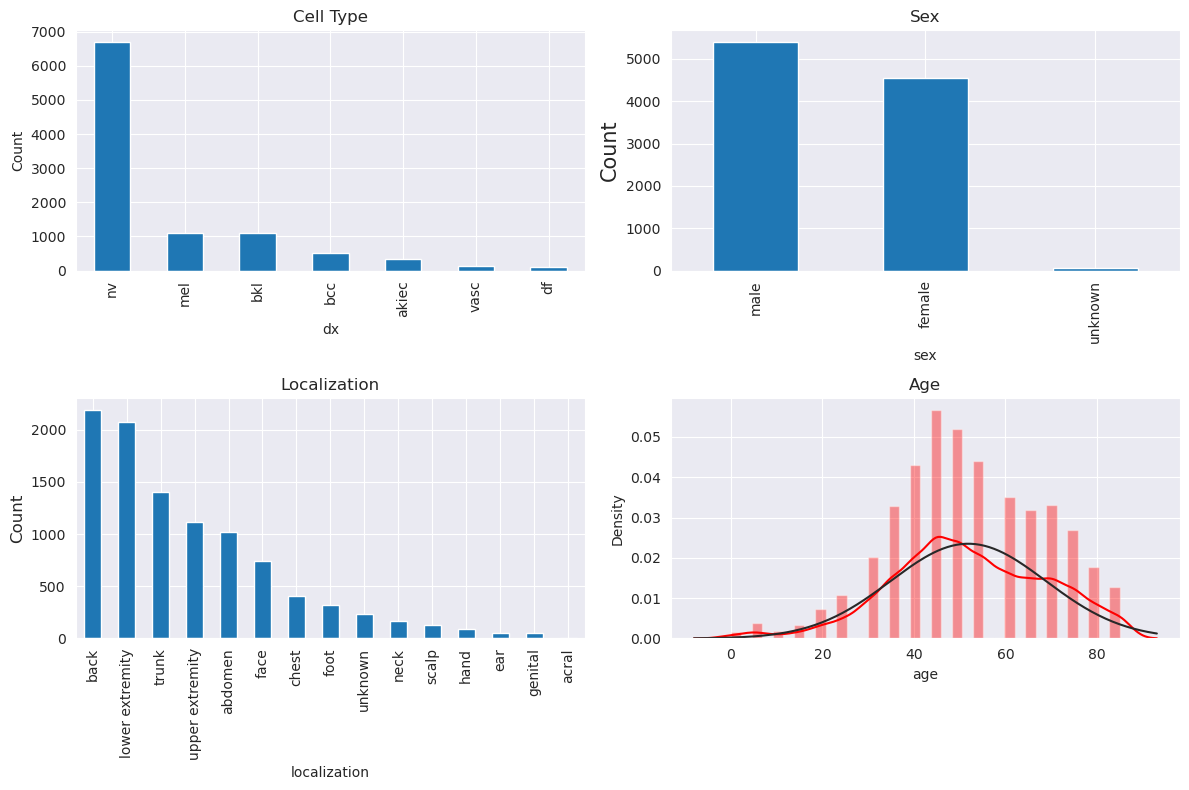

In [44]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

# Check Class Distribution

In [45]:
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


The dataset is imbalanced, with the majority of the samples belonging to the class `5` or 'nv'.

# Balancing The Classes

In [46]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [47]:
n_samples=6500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [48]:
# Concat the balanced dataframes
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, df_2_balanced, df_3_balanced, df_4_balanced, df_5_balanced, df_6_balanced])

In [49]:
# Class distribution after balancing
print(skin_df_balanced['label'].value_counts())

label
0    6500
1    6500
2    6500
3    6500
4    6500
5    6500
6    6500
Name: count, dtype: int64


Dataset has been balanced

# Loading Images

In [50]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('/home/craib/Desktop/SCDS_Datasets/Skin Cancer Datasets/H10K/', '*', '*.jpg'))}

In [51]:
IMG_SIZE = 32 # Resize the images into 32x32

skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((IMG_SIZE,IMG_SIZE))))

### Plot Images From Each Class

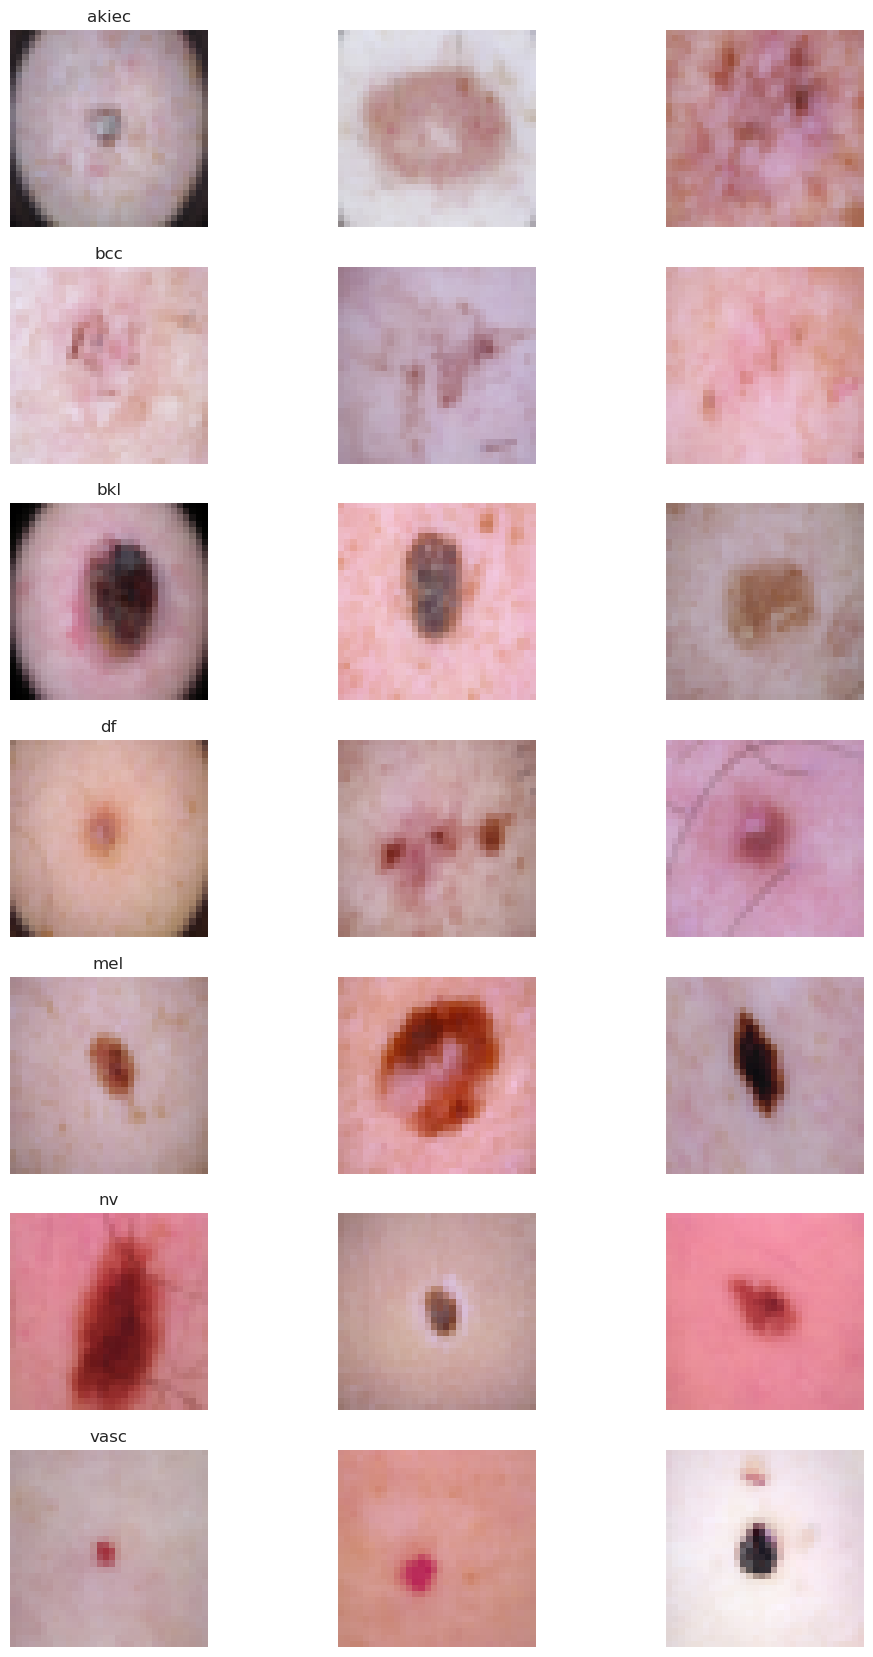

In [52]:
n_samples = 3 # Plot 3 samples

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Normalize Data

In [53]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X / 255.

# Assign labels to Y variable
Y = skin_df_balanced['label']
Y_cat = to_categorical(Y, num_classes=7)

# Split Data

In [54]:
x_train, x_temp, y_train, y_temp = train_test_split(X, Y_cat, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.75, random_state=42)

# Define Model

In [55]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['acc'])

/home/craib/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

# Training The Model

In [56]:
batch_size = 16 
epochs = 200

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    verbose=2
)

Epoch 1/200
1707/1707 - 33s - 19ms/step - acc: 0.3818 - loss: 1.5141 - val_acc: 0.5505 - val_loss: 1.1872
Epoch 2/200
1707/1707 - 32s - 19ms/step - acc: 0.5339 - loss: 1.1922 - val_acc: 0.5747 - val_loss: 1.0910
Epoch 3/200
1707/1707 - 31s - 18ms/step - acc: 0.5909 - loss: 1.0625 - val_acc: 0.6512 - val_loss: 0.9344
Epoch 4/200
1707/1707 - 31s - 18ms/step - acc: 0.6290 - loss: 0.9662 - val_acc: 0.7198 - val_loss: 0.7759
Epoch 5/200
1707/1707 - 35s - 20ms/step - acc: 0.6543 - loss: 0.8997 - val_acc: 0.7446 - val_loss: 0.7307
Epoch 6/200
1707/1707 - 31s - 18ms/step - acc: 0.6778 - loss: 0.8419 - val_acc: 0.7442 - val_loss: 0.6997
Epoch 7/200
1707/1707 - 31s - 18ms/step - acc: 0.6912 - loss: 0.8042 - val_acc: 0.7765 - val_loss: 0.6161
Epoch 8/200
1707/1707 - 32s - 19ms/step - acc: 0.7079 - loss: 0.7716 - val_acc: 0.7776 - val_loss: 0.6196
Epoch 9/200
1707/1707 - 32s - 18ms/step - acc: 0.7155 - loss: 0.7452 - val_acc: 0.8064 - val_loss: 0.5577
Epoch 10/200
1707/1707 - 31s - 18ms/step - acc

## Plot Training History

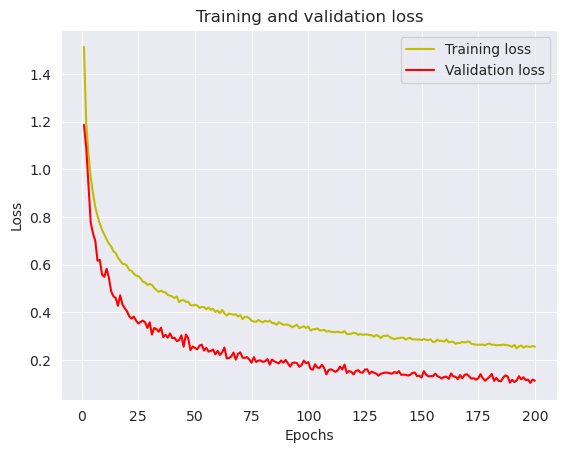

In [57]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

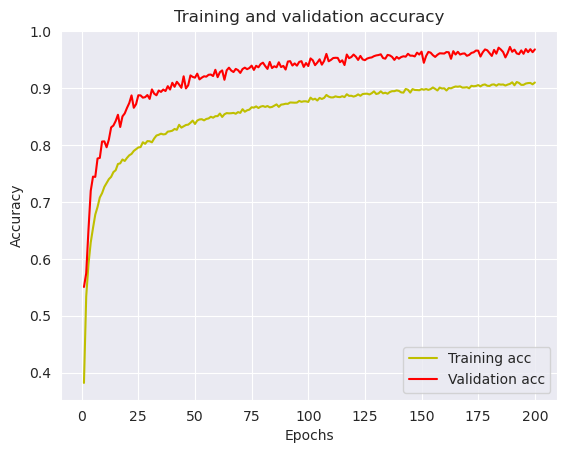

In [58]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluating The Model

In [59]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.9639 - loss: 0.1160
Test accuracy: 0.9645421504974365


In [60]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


### Classification Report

In [61]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2013
           1       0.98      1.00      0.99      1885
           2       0.89      0.98      0.93      1902
           3       1.00      1.00      1.00      1947
           4       0.94      0.93      0.94      1989
           5       0.95      0.84      0.89      1946
           6       1.00      1.00      1.00      1968

    accuracy                           0.96     13650
   macro avg       0.96      0.96      0.96     13650
weighted avg       0.97      0.96      0.96     13650



### Connfusion Matrix

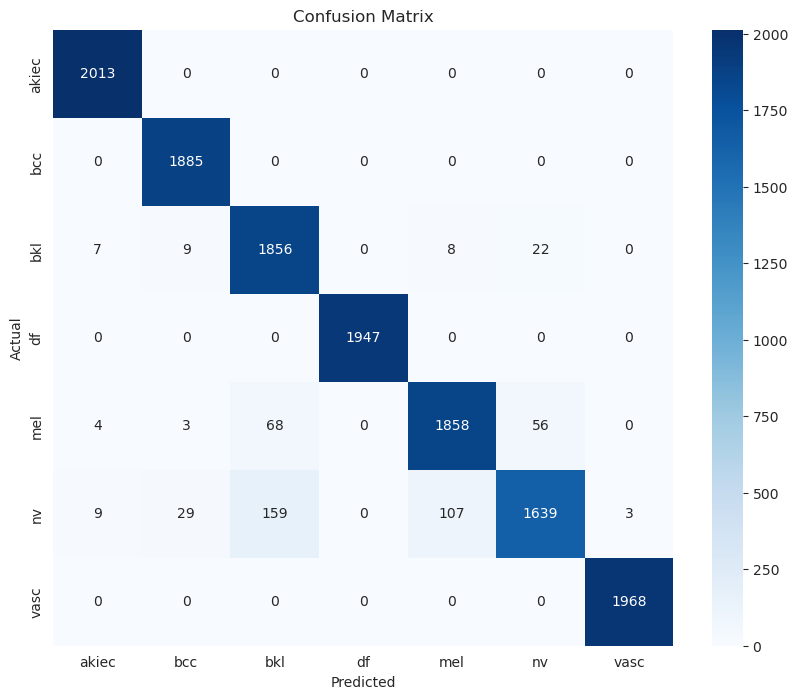

In [62]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save Model

In [63]:
model.save('/home/craib/Desktop/SCDS_Datasets/Skin Cancer Datasets/5/Saved_Models/SCDSNet-H10K_Model-2.keras')

# Predicting Image Labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to akiec class.


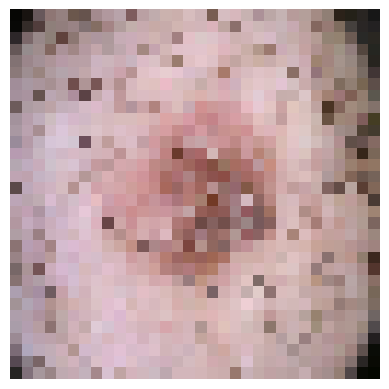

In [64]:
img_path = '/home/craib/Desktop/SCDS_Datasets/Skin Cancer Datasets/H10K/HAM10000_images_part_2/ISIC_0033550.jpg'
img = image.load_img(img_path, target_size=(32, 32))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array/255.0

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} class.".format(classes[np.argmax(score)]))

plt.imshow(img)
plt.axis('off')
plt.show()